In [542]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [543]:
# ============================
# Load data
# ============================
df = pd.read_csv("plan_purchase.csv")

print(df.head())

   Age  MonthlyIncome  PlanType  UsageScore Purchase
0   56          81476  Standard          90      Yes
1   46          64811  Standard          92      Yes
2   32          56208     Basic          71      Yes
3   25          40150   Premium          82      Yes
4   38          63286  Standard          34       No


In [544]:
# ============================
# Features & target
# ============================
X = df.drop("Purchase", axis=1)
y = df["Purchase"].map({"No": 0, "Yes": 1})  # Convert Yes/No → 1/0


In [545]:
# ============================
# Identify feature types
# ============================
categorical_features = X.select_dtypes(include="object").columns
numeric_features = X.select_dtypes(exclude="object").columns

print("Categorical Features:", list(categorical_features))
print("Numeric Features:", list(numeric_features))

Categorical Features: ['PlanType']
Numeric Features: ['Age', 'MonthlyIncome', 'UsageScore']


In [546]:
# Numeric pipeline (Random Forest does NOT need scaling)
numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent"))
])

# Categorical pipeline
categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])


In [547]:
# ============================
# Column Transformer
# ============================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat", categorical_pipe, categorical_features)
    ]
)

#print(preprocessor)

In [548]:
# ============================
# Model
# ============================
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    oob_score=True,
    n_jobs=-1
)

In [549]:
# ============================
# Full Pipeline
# ============================
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf)
])


In [550]:
# ============================
# Train-test split
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [551]:
# ============================
# Train
# ============================
pipeline.fit(X_train, y_train)


# ============================
# Evaluate
# ============================
y_pred = pipeline.predict(X_test)

In [552]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("OOB Score:", pipeline.named_steps["model"].oob_score_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.99
OOB Score: 0.995
Confusion Matrix:
 [[56  0]
 [ 1 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        56
           1       1.00      0.98      0.99        44

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



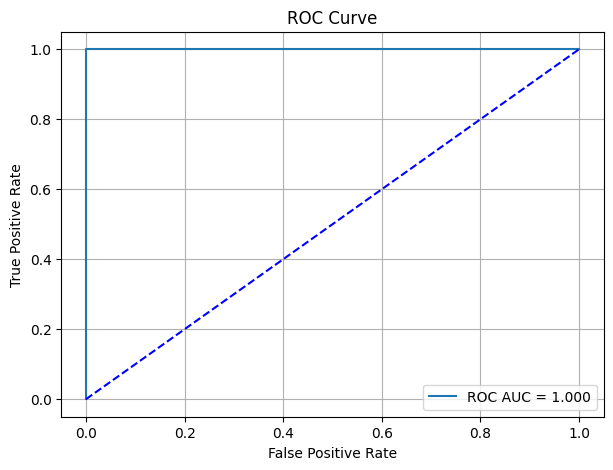

In [553]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities (IMPORTANT)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="blue")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [554]:
new_customer = pd.DataFrame(
    {
        "Age" : [30],
        "MonthlyIncome": [55000],
        "PlanType" : ["Premium"],
        "UsageScore": [65]
    }
)

prediction = pipeline.predict(new_customer)
prob = pipeline.predict_proba(new_customer)

print("Results")
print(" - " * 30)
print(prediction)
print(f" {prob[0][1]:.2%}" )

Results
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
[1]
 100.00%


In [557]:
X.shape[0]
X_train.shape[0]
X_test.shape[0]

100